# CHIRPS Rainfall Data Extraction for Syria

This notebook extracts CHIRPS rainfall data from Google Earth Engine for Syria at ADM0 (national) and ADM1 (governorate) levels.

In [2]:
# Import required libraries
import ee
import pandas as pd
import geopandas as gpd
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# Authenticate Google Earth Engine
try:
    # First try with service account if available
    service_account_file = '../../training-253313-c905674c1ca0.json'
    if Path(service_account_file).exists():
        print(f"Authenticating with service account: {service_account_file}")
        credentials = ee.ServiceAccountCredentials(None, service_account_file)
        ee.Initialize(credentials)
        print("✓ Google Earth Engine initialized with service account")
    else:
        raise FileNotFoundError("Service account file not found")
except Exception as e:
    print(f"Service account auth failed: {e}")
    print("Trying user authentication...")
    try:
        ee.Initialize()
        print("✓ Google Earth Engine already initialized")
    except:
        print("Authenticating with user credentials...")
        ee.Authenticate()
        ee.Initialize()
        print("✓ Google Earth Engine authenticated and initialized")

Authenticating with service account: ../../training-253313-c905674c1ca0.json
✓ Google Earth Engine initialized with service account
✓ Google Earth Engine initialized with service account


In [4]:
# Set parameters
start_date = '2012-01-01'
end_date = '2025-09-30'
temporal_resolution = 'monthly'

# Syria bounding box
syria_bbox = ee.Geometry.Rectangle([35.7, 32.3, 42.4, 37.3])

print(f"Extracting rainfall data from {start_date} to {end_date}")
print(f"Temporal resolution: {temporal_resolution}")

Extracting rainfall data from 2012-01-01 to 2025-09-30
Temporal resolution: monthly


## 1. Extract National-Level (ADM0) Rainfall

In [5]:
# Load CHIRPS dataset
print("Loading CHIRPS dataset...")
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate(start_date, end_date) \
    .filterBounds(syria_bbox)

# Aggregate to monthly
def monthly_sum(date):
    date = ee.Date(date)
    monthly = chirps.filterDate(date, date.advance(1, 'month')).sum()
    return monthly.set('system:time_start', date.millis())

# Get list of monthly dates
start = ee.Date(start_date)
end = ee.Date(end_date)
months = end.difference(start, 'month').round()
monthly_dates = ee.List.sequence(0, months.subtract(1)).map(
    lambda m: start.advance(m, 'month')
)

chirps_monthly = ee.ImageCollection.fromImages(monthly_dates.map(monthly_sum))
print(f"✓ Created monthly aggregation")

Loading CHIRPS dataset...
✓ Created monthly aggregation


In [6]:
# Extract national-level rainfall
print("Extracting national-level rainfall...")

def extract_rainfall(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=syria_bbox,
        scale=5000,  # 5km resolution
        maxPixels=1e9
    )
    
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'rainfall_mm': stats.get('precipitation'),
        'region': 'Syria'
    })

features = chirps_monthly.map(extract_rainfall)
data = features.getInfo()

# Convert to DataFrame
records_adm0 = []
for feature in data['features']:
    props = feature['properties']
    if props['rainfall_mm'] is not None:
        records_adm0.append({
            'region': props['region'],
            'date': pd.to_datetime(props['date']),
            'rainfall_mm': props['rainfall_mm']
        })

df_adm0 = pd.DataFrame(records_adm0)
df_adm0 = df_adm0.sort_values('date').reset_index(drop=True)

print(f"✓ Extracted {len(df_adm0)} national-level records")
df_adm0.head()

Extracting national-level rainfall...
✓ Extracted 165 national-level records
✓ Extracted 165 national-level records


,region,date,rainfall_mm
0,Syria,2012-01-01,58.571585
1,Syria,2012-02-01,45.174389
2,Syria,2012-03-01,29.882331
3,Syria,2012-04-01,18.387744
4,Syria,2012-05-01,13.621918


In [7]:
# Save ADM0 data
output_dir = Path('../../data/rainfall')
output_dir.mkdir(parents=True, exist_ok=True)

output_file_adm0 = output_dir / f'syria_chirps_rainfall_{start_date}_{end_date}_monthly_adm0.csv'
df_adm0.to_csv(output_file_adm0, index=False)
print(f"✓ Saved to: {output_file_adm0}")

✓ Saved to: ../../data/rainfall/syria_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm0.csv


## 2. Extract Governorate-Level (ADM1) Rainfall

In [8]:
# Load Syria ADM1 boundaries
print("Loading Syria ADM1 boundaries...")
boundaries_path = '../../data/boundaries/syr_admin1.shp'
syr_adm1 = gpd.read_file(boundaries_path)

# Ensure CRS is WGS84
if syr_adm1.crs is None:
    syr_adm1 = syr_adm1.set_crs('EPSG:4326')
elif syr_adm1.crs != 'EPSG:4326':
    syr_adm1 = syr_adm1.to_crs('EPSG:4326')

print(f"✓ Loaded {len(syr_adm1)} governorates")
print(f"\nGovernorates: {sorted(syr_adm1['NAME_EN'].unique())}")

Loading Syria ADM1 boundaries...
✓ Loaded 14 governorates

Governorates: ['Al-Hasakeh', 'Aleppo', 'Ar-Raqqa', 'As-Sweida', 'Damascus', "Dar'a", 'Deir-ez-Zor', 'Hama', 'Homs', 'Idleb', 'Lattakia', 'Quneitra', 'Rural Damascus', 'Tartous']


In [9]:
# Extract rainfall for each governorate
print("\nExtracting rainfall by governorate (this may take several minutes)...")
all_results = []

for idx, region in syr_adm1.iterrows():
    region_name = region['NAME_EN']
    print(f"Processing {idx+1}/{len(syr_adm1)}: {region_name}")
    
    # Convert geometry to GEE format
    geom_json = region.geometry.__geo_interface__
    ee_geom = ee.Geometry(geom_json)
    
    # Extract rainfall for this region
    def extract_regional_rainfall(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=ee_geom,
            scale=5000,
            maxPixels=1e9
        )
        
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'rainfall_mm': stats.get('precipitation'),
            'region': region_name
        })
    
    try:
        features = chirps_monthly.map(extract_regional_rainfall)
        data = features.getInfo()
        
        # Add to results
        for feature in data['features']:
            props = feature['properties']
            if props['rainfall_mm'] is not None:
                all_results.append({
                    'region': props['region'],
                    'date': pd.to_datetime(props['date']),
                    'rainfall_mm': props['rainfall_mm']
                })
    except Exception as e:
        print(f"  ⚠ Error processing {region_name}: {e}")
        continue

# Create DataFrame
df_adm1 = pd.DataFrame(all_results)
df_adm1 = df_adm1.sort_values(['region', 'date']).reset_index(drop=True)

print(f"\n✓ Extracted {len(df_adm1)} governorate-date records")
print(f"✓ Number of governorates: {df_adm1['region'].nunique()}")


Extracting rainfall by governorate (this may take several minutes)...
Processing 1/14: Damascus
Processing 2/14: Aleppo
Processing 2/14: Aleppo
Processing 3/14: Rural Damascus
Processing 3/14: Rural Damascus
Processing 4/14: Homs
Processing 4/14: Homs
Processing 5/14: Hama
Processing 5/14: Hama
Processing 6/14: Lattakia
Processing 6/14: Lattakia
Processing 7/14: Idleb
Processing 7/14: Idleb
Processing 8/14: Al-Hasakeh
Processing 8/14: Al-Hasakeh
Processing 9/14: Deir-ez-Zor
Processing 9/14: Deir-ez-Zor
Processing 10/14: Tartous
Processing 10/14: Tartous
Processing 11/14: Ar-Raqqa
Processing 11/14: Ar-Raqqa
Processing 12/14: Dar'a
Processing 12/14: Dar'a
Processing 13/14: As-Sweida
Processing 13/14: As-Sweida
Processing 14/14: Quneitra
Processing 14/14: Quneitra

✓ Extracted 2310 governorate-date records
✓ Number of governorates: 14

✓ Extracted 2310 governorate-date records
✓ Number of governorates: 14


In [10]:
# Preview the data
df_adm1.head(10)

,region,date,rainfall_mm
0,Al-Hasakeh,2012-01-01,46.018478
1,Al-Hasakeh,2012-02-01,40.837759
2,Al-Hasakeh,2012-03-01,37.684584
3,Al-Hasakeh,2012-04-01,43.845778
4,Al-Hasakeh,2012-05-01,19.963631
5,Al-Hasakeh,2012-06-01,0.000000
6,Al-Hasakeh,2012-07-01,0.000000
7,Al-Hasakeh,2012-08-01,0.000000
8,Al-Hasakeh,2012-09-01,0.000000
9,Al-Hasakeh,2012-10-01,30.355283


In [11]:
# Save ADM1 data
output_file_adm1 = output_dir / f'syria_chirps_rainfall_{start_date}_{end_date}_monthly_adm1.csv'
df_adm1.to_csv(output_file_adm1, index=False)
print(f"✓ Saved to: {output_file_adm1}")

✓ Saved to: ../../data/rainfall/syria_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm1.csv


## 3. Extract Sub-Governorate Level (ADM2) Rainfall

In [25]:
# Load Syria ADM2 boundaries
print("Loading Syria ADM2 boundaries...")
boundaries_path_adm2 = '../../data/boundaries/syr_admin2.shp'
syr_adm2 = gpd.read_file(boundaries_path_adm2)

# Ensure CRS is WGS84
if syr_adm2.crs is None:
    syr_adm2 = syr_adm2.set_crs('EPSG:4326')
elif syr_adm2.crs != 'EPSG:4326':
    syr_adm2 = syr_adm2.to_crs('EPSG:4326')

print(f"✓ Loaded {len(syr_adm2)} sub-governorate regions")
print(f"\nSample regions: {sorted(syr_adm2['NAME_EN'].unique())[:10]}")

Loading Syria ADM2 boundaries...
✓ Loaded 62 sub-governorate regions

Sample regions: ["A'zaz", 'Abu Kamal', 'Afrin', 'Ain Al Arab', 'Al Bab', 'Al Fiq', "Al Ma'ra", 'Al Makhrim', 'Al Mayadin', 'Al Qutayfah']


In [26]:
# Extract rainfall for each ADM2 region
print("\nExtracting rainfall by sub-governorate (this may take several minutes)...")
all_results_adm2 = []

for idx, region in syr_adm2.iterrows():
    region_name = region['NAME_EN']
    print(f"Processing {idx+1}/{len(syr_adm2)}: {region_name}")
    
    # Convert geometry to GEE format
    geom_json = region.geometry.__geo_interface__
    ee_geom = ee.Geometry(geom_json)
    
    # Extract rainfall for this region
    def extract_adm2_rainfall(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=ee_geom,
            scale=5000,
            maxPixels=1e9
        )
        
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'rainfall_mm': stats.get('precipitation'),
            'region': region_name
        })
    
    try:
        features = chirps_monthly.map(extract_adm2_rainfall)
        data = features.getInfo()
        
        # Add to results
        for feature in data['features']:
            props = feature['properties']
            if props['rainfall_mm'] is not None:
                all_results_adm2.append({
                    'region': props['region'],
                    'date': pd.to_datetime(props['date']),
                    'rainfall_mm': props['rainfall_mm']
                })
    except Exception as e:
        print(f"  ⚠ Error processing {region_name}: {e}")
        continue

# Create DataFrame
df_adm2 = pd.DataFrame(all_results_adm2)
df_adm2 = df_adm2.sort_values(['region', 'date']).reset_index(drop=True)

print(f"\n✓ Extracted {len(df_adm2)} sub-governorate-date records")
print(f"✓ Number of sub-governorate regions: {df_adm2['region'].nunique()}")


Extracting rainfall by sub-governorate (this may take several minutes)...
Processing 1/62: Damascus
Processing 2/62: Jebel Saman
Processing 3/62: Al Bab
Processing 4/62: Afrin
Processing 5/62: A'zaz
Processing 6/62: Menbij
Processing 7/62: Ain Al Arab
Processing 8/62: As-Safira
Processing 9/62: Jarablus
Processing 10/62: Rural Damascus
Processing 11/62: Duma
Processing 12/62: Al Qutayfah
Processing 13/62: At Tall
Processing 14/62: Yabroud
Processing 15/62: An Nabk
Processing 16/62: Az-Zabdani
Processing 17/62: Qatana
Processing 18/62: Darayya
Processing 19/62: Homs
Processing 20/62: Al-Qusayr
Processing 21/62: Tall Kalakh
Processing 22/62: Ar-Rastan
Processing 23/62: Tadmor
Processing 24/62: Al Makhrim
Processing 25/62: Hama
Processing 26/62: As-Suqaylabiyah
Processing 27/62: As-Salamiyeh
Processing 28/62: Masyaf
Processing 29/62: Muhradah
Processing 30/62: Lattakia
Processing 31/62: Jablah
Processing 32/62: Al-Haffa
Processing 33/62: Al-Qardaha
Processing 34/62: Idleb
Processing 35/6

In [27]:
# Preview the ADM2 data
df_adm2.head(10)

,region,date,rainfall_mm
0,A'zaz,2012-01-01,118.384909
1,A'zaz,2012-02-01,94.512800
2,A'zaz,2012-03-01,32.620026
3,A'zaz,2012-04-01,21.846738
4,A'zaz,2012-05-01,19.861725
5,A'zaz,2012-06-01,0.003950
6,A'zaz,2012-07-01,0.000000
7,A'zaz,2012-08-01,0.000000
8,A'zaz,2012-09-01,0.000000
9,A'zaz,2012-10-01,49.938345


In [28]:
# Save ADM2 data
output_file_adm2 = output_dir / f'syria_chirps_rainfall_{start_date}_{end_date}_monthly_adm2.csv'
df_adm2.to_csv(output_file_adm2, index=False)
print(f"✓ Saved to: {output_file_adm2}")

✓ Saved to: ../../data/rainfall/syria_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm2.csv


## 3. Extract District-Level (ADM3) Rainfall

In [21]:
# Load Syria ADM3 boundaries
print("Loading Syria ADM3 boundaries...")
boundaries_path_adm3 = '../../data/boundaries/syr_admin3.shp'
syr_adm3 = gpd.read_file(boundaries_path_adm3)

# Ensure CRS is WGS84
if syr_adm3.crs is None:
    syr_adm3 = syr_adm3.set_crs('EPSG:4326')
elif syr_adm3.crs != 'EPSG:4326':
    syr_adm3 = syr_adm3.to_crs('EPSG:4326')

print(f"✓ Loaded {len(syr_adm3)} districts")
print(f"\nSample districts: {sorted(syr_adm3['NAME_EN'].unique())[:10]}")

Loading Syria ADM3 boundaries...
✓ Loaded 272 districts

Sample districts: ["A'rima", "A'zaz", 'Abu Kamal', 'Abu Qalqal', 'Abul Thohur', 'Afrin', 'Aghtrin', 'Ain al Arab', 'Al Bab', 'Al Makhrim']


In [22]:
# Extract rainfall for each district
print("\nExtracting rainfall by district (this will take longer due to more regions)...")
all_results_adm3 = []

for idx, district in syr_adm3.iterrows():
    district_name = district['NAME_EN']
    print(f"Processing {idx+1}/{len(syr_adm3)}: {district_name}")
    
    # Convert geometry to GEE format
    geom_json = district.geometry.__geo_interface__
    ee_geom = ee.Geometry(geom_json)
    
    # Extract rainfall for this district
    def extract_district_rainfall(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=ee_geom,
            scale=5000,
            maxPixels=1e9
        )
        
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'rainfall_mm': stats.get('precipitation'),
            'district': district_name
        })
    
    try:
        features = chirps_monthly.map(extract_district_rainfall)
        data = features.getInfo()
        
        # Add to results
        for feature in data['features']:
            props = feature['properties']
            if props['rainfall_mm'] is not None:
                all_results_adm3.append({
                    'district': props['district'],
                    'date': pd.to_datetime(props['date']),
                    'rainfall_mm': props['rainfall_mm']
                })
    except Exception as e:
        print(f"  ⚠ Error processing {district_name}: {e}")
        continue

# Create DataFrame
df_adm3 = pd.DataFrame(all_results_adm3)
df_adm3 = df_adm3.sort_values(['district', 'date']).reset_index(drop=True)

print(f"\n✓ Extracted {len(df_adm3)} district-date records")
print(f"✓ Number of districts: {df_adm3['district'].nunique()}")


Extracting rainfall by district (this will take longer due to more regions)...
Processing 1/272: Damascus


Processing 2/272: Jebel Saman
Processing 3/272: Atareb
Processing 4/272: Tall Ed-daman
Processing 5/272: Haritan
Processing 6/272: Daret Azza
Processing 7/272: Zarbah
Processing 8/272: Hadher
Processing 9/272: Al Bab
Processing 10/272: Tadaf
Processing 11/272: Dayr Hafir
Processing 12/272: Ar-Ra'ee
Processing 13/272: Eastern Kwaires
Processing 14/272: Rasm Haram El-Imam
Processing 15/272: A'rima
Processing 16/272: Afrin
Processing 17/272: Bulbul
Processing 18/272: Jandairis
Processing 19/272: Raju
Processing 20/272: Sharan
Processing 21/272: Sheikh El-Hadid
Processing 22/272: Ma'btali
Processing 23/272: A'zaz
Processing 24/272: Aghtrin
Processing 25/272: Tall Refaat
Processing 26/272: Mare'
Processing 27/272: Nabul
Processing 28/272: Suran
Processing 29/272: Menbij
Processing 30/272: Abu Qalqal
Processing 31/272: Al-Khafsa
Processing 32/272: Maskana
Processing 33/272: Ain al Arab
Processing 34/272: Lower Shyookh
Processing 35/272: Sarin
Processing 36/272: As-Safira
Processing 37/272: K

In [23]:
# Preview the ADM3 data
df_adm3.head(10)

,district,date,rainfall_mm
0,A'rima,2012-01-01,93.431315
1,A'rima,2012-02-01,77.014129
2,A'rima,2012-03-01,27.587833
3,A'rima,2012-04-01,19.341973
4,A'rima,2012-05-01,17.299611
5,A'rima,2012-06-01,0.000000
6,A'rima,2012-07-01,0.000000
7,A'rima,2012-08-01,0.000000
8,A'rima,2012-09-01,0.000000
9,A'rima,2012-10-01,36.125836


In [24]:
# Save ADM3 data
output_file_adm3 = output_dir / f'syria_chirps_rainfall_{start_date}_{end_date}_monthly_adm3.csv'
df_adm3.to_csv(output_file_adm3, index=False)
print(f"✓ Saved to: {output_file_adm3}")

✓ Saved to: ../../data/rainfall/syria_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm3.csv


## Summary

In [ ]:
print("="*60)
print("EXTRACTION COMPLETE - SYRIA RAINFALL DATA")
print("="*60)

print("\n--- ADMIN LEVEL 0 (National) ---")
print(f"Total records: {len(df_adm0)}")
print(f"Date range: {df_adm0['date'].min()} to {df_adm0['date'].max()}")
print(f"File: {output_file_adm0}")

print("\n--- ADMIN LEVEL 1 (Governorates) ---")
print(f"Total records: {len(df_adm1)}")
print(f"Number of governorates: {df_adm1['region'].nunique()}")
print(f"Date range: {df_adm1['date'].min()} to {df_adm1['date'].max()}")
print(f"File: {output_file_adm1}")

print(f"\nGovernorates included:")
for region in sorted(df_adm1['region'].unique()):
    count = len(df_adm1[df_adm1['region'] == region])
    print(f"  - {region}: {count} records")

# Include ADM2 summary if data exists
try:
    print("\n--- ADMIN LEVEL 2 (Sub-Governorates) ---")
    print(f"Total records: {len(df_adm2)}")
    print(f"Number of sub-governorate regions: {df_adm2['region'].nunique()}")
    print(f"Date range: {df_adm2['date'].min()} to {df_adm2['date'].max()}")
    print(f"File: {output_file_adm2}")
    print(f"\nSample regions: {sorted(df_adm2['region'].unique())[:5]}")
except NameError:
    print("\n--- ADMIN LEVEL 2 (Sub-Governorates) ---")
    print("Not yet extracted. Run the ADM2 extraction cells above.")

# Include ADM3 summary if data exists
try:
    print("\n--- ADMIN LEVEL 3 (Districts) ---")
    print(f"Total records: {len(df_adm3)}")
    print(f"Number of districts: {df_adm3['district'].nunique()}")
    print(f"Date range: {df_adm3['date'].min()} to {df_adm3['date'].max()}")
    print(f"File: {output_file_adm3}")
    print(f"\nSample districts: {sorted(df_adm3['district'].unique())[:5]}")
except NameError:
    print("\n--- ADMIN LEVEL 3 (Districts) ---")
    print("Not yet extracted. Run the ADM3 extraction cells above.")

EXTRACTION COMPLETE - SYRIA RAINFALL DATA

--- ADMIN LEVEL 0 (National) ---
Total records: 165
Date range: 2012-01-01 00:00:00 to 2025-09-01 00:00:00
File: ../../data/rainfall/syria_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm0.csv

--- ADMIN LEVEL 1 (Governorates) ---
Total records: 2310
Number of governorates: 14
Date range: 2012-01-01 00:00:00 to 2025-09-01 00:00:00
File: ../../data/rainfall/syria_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm1.csv

Governorates included:
  - Al-Hasakeh: 165 records
  - Aleppo: 165 records
  - Ar-Raqqa: 165 records
  - As-Sweida: 165 records
  - Damascus: 165 records
  - Dar'a: 165 records
  - Deir-ez-Zor: 165 records
  - Hama: 165 records
  - Homs: 165 records
  - Idleb: 165 records
  - Lattakia: 165 records
  - Quneitra: 165 records
  - Rural Damascus: 165 records
  - Tartous: 165 records


## Visualization: Annual Rainfall Patterns

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Add year and month columns for analysis
df_adm0['year'] = df_adm0['date'].dt.year
df_adm0['month'] = df_adm0['date'].dt.month

df_adm1['year'] = df_adm1['date'].dt.year
df_adm1['month'] = df_adm1['date'].dt.month

# Calculate annual rainfall
annual_adm0 = df_adm0.groupby('year')['rainfall_mm'].sum().reset_index()
annual_adm1 = df_adm1.groupby(['region', 'year'])['rainfall_mm'].sum().reset_index()

print(f"Annual rainfall data prepared")
print(f"Years covered: {annual_adm0['year'].min()} to {annual_adm0['year'].max()}")

Annual rainfall data prepared
Years covered: 2012 to 2025


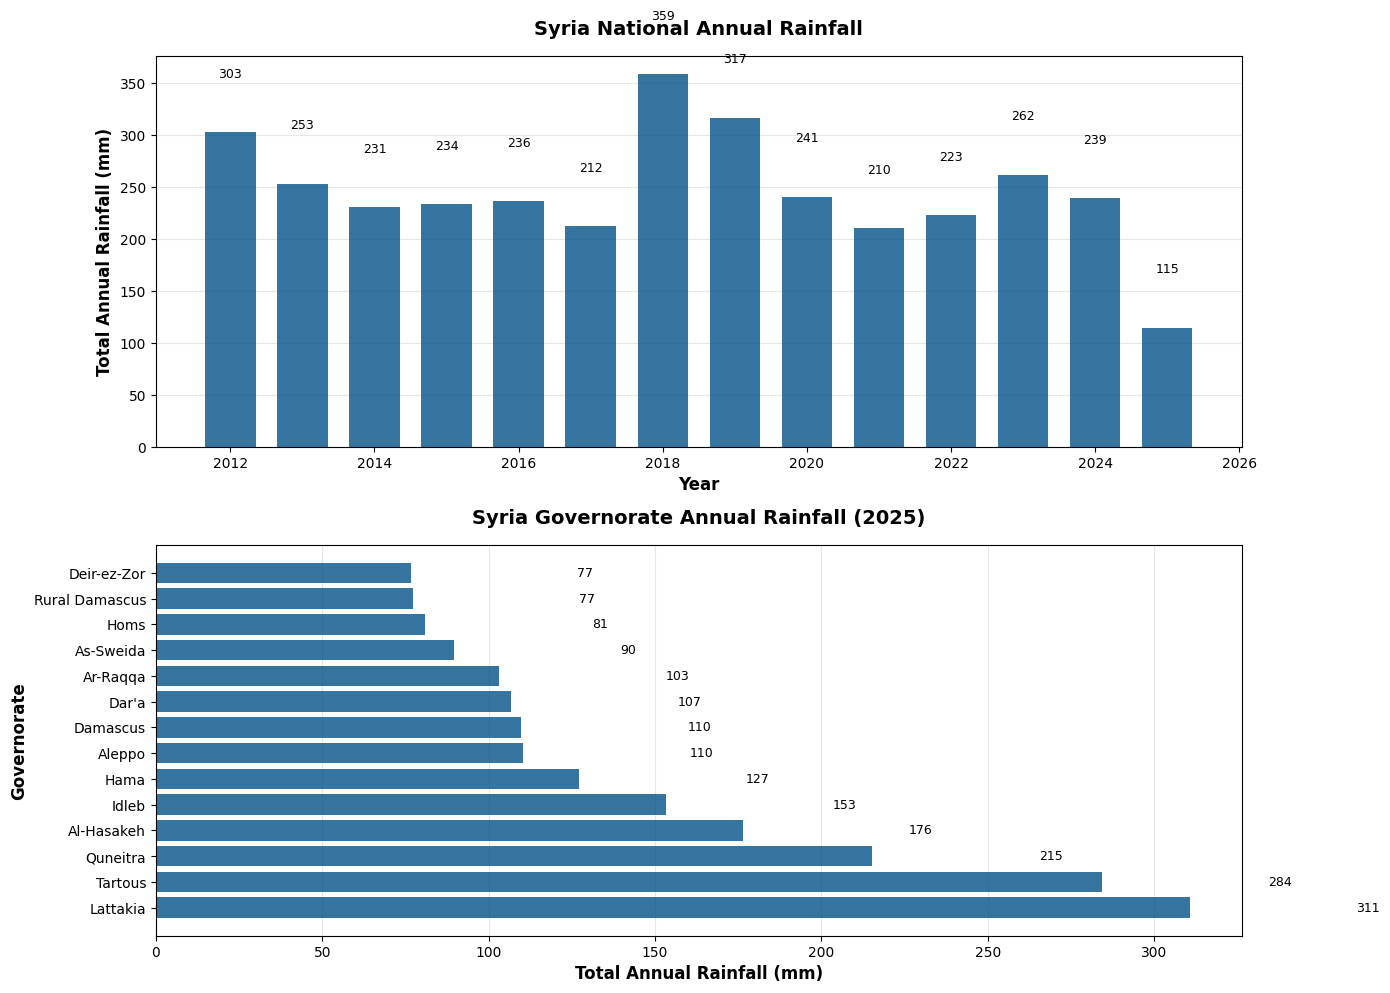


✓ Plots generated successfully


In [14]:
# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: National annual rainfall
ax1 = axes[0]
ax1.bar(annual_adm0['year'], annual_adm0['rainfall_mm'], color='#025288', alpha=0.8, width=0.7)
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Annual Rainfall (mm)', fontsize=12, fontweight='bold')
ax1.set_title('Syria National Annual Rainfall', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_axisbelow(True)

# Add value labels on bars
for year, rainfall in zip(annual_adm0['year'], annual_adm0['rainfall_mm']):
    ax1.text(year, rainfall + 50, f'{rainfall:.0f}', 
             ha='center', va='bottom', fontsize=9)

# Plot 2: Regional annual rainfall (2024 comparison)
ax2 = axes[1]
latest_year = annual_adm1['year'].max()
regional_latest = annual_adm1[annual_adm1['year'] == latest_year].sort_values('rainfall_mm', ascending=False)

bars = ax2.barh(regional_latest['region'], regional_latest['rainfall_mm'], 
                color='#025288', alpha=0.8)
ax2.set_xlabel('Total Annual Rainfall (mm)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Governorate', fontsize=12, fontweight='bold')
ax2.set_title(f'Syria Governorate Annual Rainfall ({latest_year})', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_axisbelow(True)

# Add value labels
for bar, rainfall in zip(bars, regional_latest['rainfall_mm']):
    width = bar.get_width()
    ax2.text(width + 50, bar.get_y() + bar.get_height()/2, f'{rainfall:.0f}',
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Plots generated successfully")

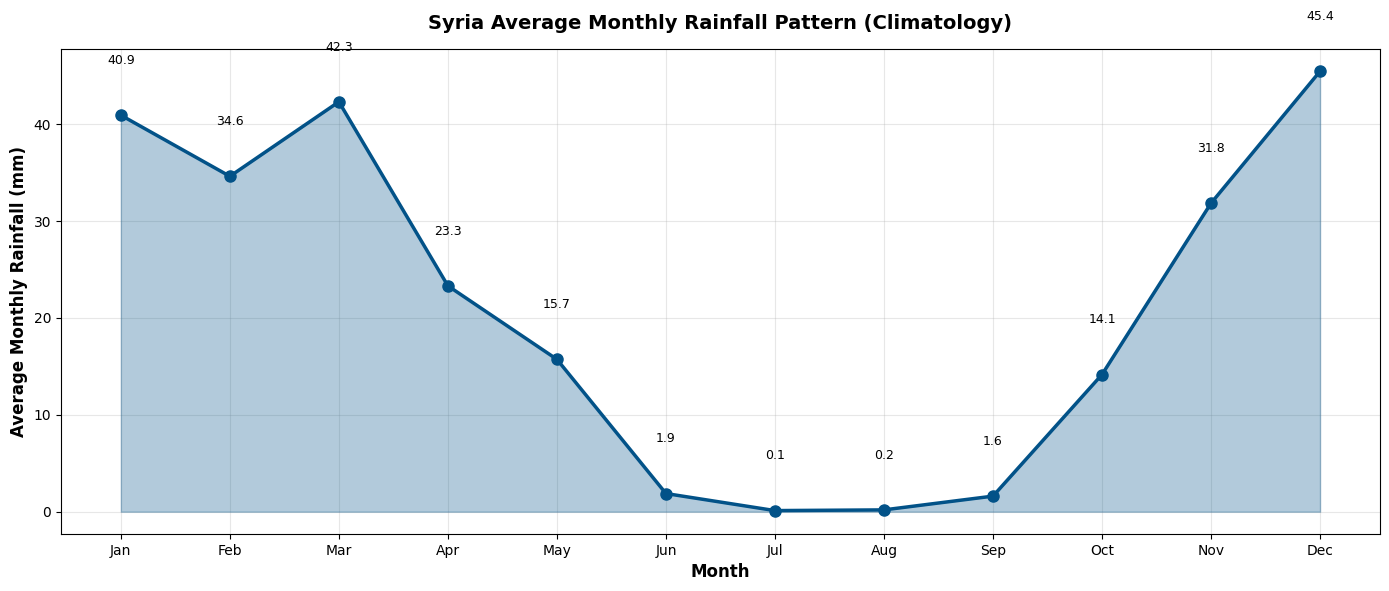


✓ Monthly climatology plot generated


In [15]:
# Additional plot: Monthly rainfall pattern (climatology)
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate average monthly rainfall across all years
monthly_pattern = df_adm0.groupby('month')['rainfall_mm'].mean().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax.plot(monthly_pattern['month'], monthly_pattern['rainfall_mm'], 
        marker='o', linewidth=2.5, markersize=8, color='#025288', label='Average')
ax.fill_between(monthly_pattern['month'], monthly_pattern['rainfall_mm'], 
                 alpha=0.3, color='#025288')

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Monthly Rainfall (mm)', fontsize=12, fontweight='bold')
ax.set_title('Syria Average Monthly Rainfall Pattern (Climatology)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Add value labels
for month, rainfall in zip(monthly_pattern['month'], monthly_pattern['rainfall_mm']):
    ax.text(month, rainfall + 5, f'{rainfall:.1f}', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Monthly climatology plot generated")

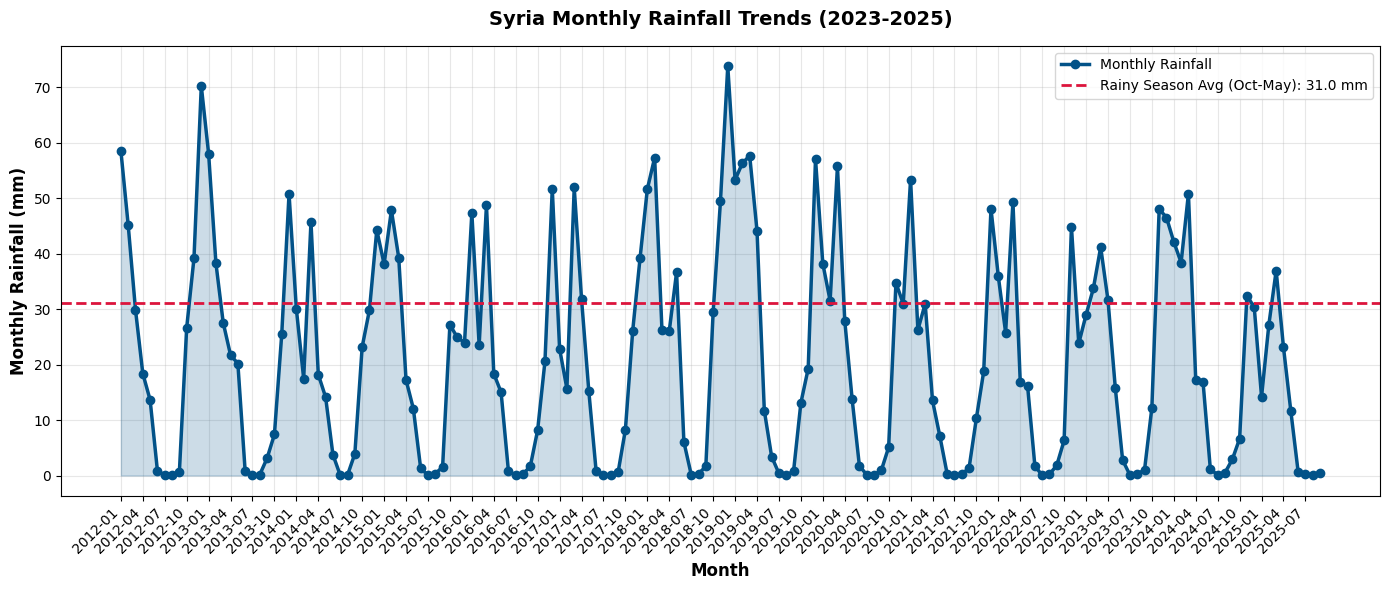


✓ Monthly rainfall trends (2023-2025) plot generated
Average monthly rainfall (Oct-May rainy season): 31.0 mm
Average monthly rainfall (all months): 20.8 mm
Maximum: 73.8 mm in 2018-12
Minimum: 0.0 mm in 2022-07


In [20]:
# Plot: Monthly rainfall trends (2023-2025)
fig, ax = plt.subplots(figsize=(14, 6))

# Filter data for 2023-2025
recent_data = df_adm0[(df_adm0['year'] >= 2010) & (df_adm0['year'] <= 2025)].copy()

# Create a readable date format for plotting
recent_data['year_month'] = recent_data['date'].dt.to_period('M').astype(str)

# Plot line chart with markers
ax.plot(range(len(recent_data)), recent_data['rainfall_mm'], 
        marker='o', linewidth=2.5, markersize=6, color='#025288', label='Monthly Rainfall')
ax.fill_between(range(len(recent_data)), recent_data['rainfall_mm'], 
                 alpha=0.2, color='#025288')

# Set x-axis labels (show every 3 months for readability)
x_positions = range(0, len(recent_data), 3)
x_labels = [recent_data.iloc[i]['year_month'] for i in x_positions]
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Rainfall (mm)', fontsize=12, fontweight='bold')
ax.set_title('Syria Monthly Rainfall Trends (2023-2025)', fontsize=14, fontweight='bold', pad=15)

ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Calculate average for rainy season (October to May)
rainy_season_data = recent_data[(recent_data['month'] >= 10) | (recent_data['month'] <= 5)]
avg_rainfall_rainy = rainy_season_data['rainfall_mm'].mean()

# Add horizontal line for rainy season average
ax.axhline(y=avg_rainfall_rainy, color='#DC143C', linestyle='--', linewidth=2, 
           label=f'Rainy Season Avg (Oct-May): {avg_rainfall_rainy:.1f} mm')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n✓ Monthly rainfall trends (2023-2025) plot generated")
print(f"Average monthly rainfall (Oct-May rainy season): {avg_rainfall_rainy:.1f} mm")
print(f"Average monthly rainfall (all months): {recent_data['rainfall_mm'].mean():.1f} mm")
print(f"Maximum: {recent_data['rainfall_mm'].max():.1f} mm in {recent_data.loc[recent_data['rainfall_mm'].idxmax(), 'year_month']}")
print(f"Minimum: {recent_data['rainfall_mm'].min():.1f} mm in {recent_data.loc[recent_data['rainfall_mm'].idxmin(), 'year_month']}")